<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

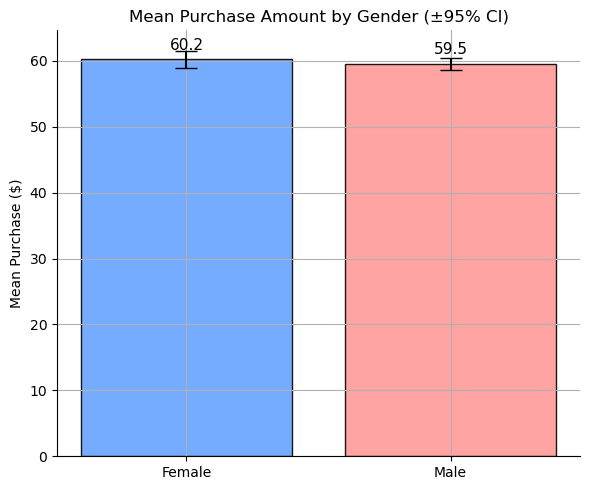

Pearson r(age, amount)=-0.010, p=0.5152, n=3900


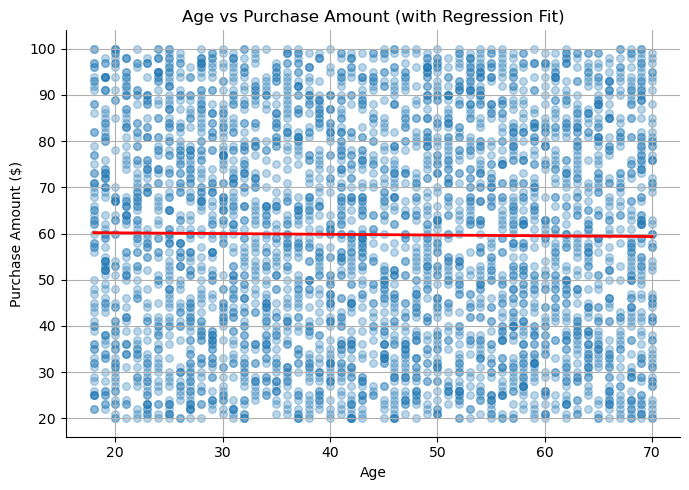


PRIMARY CONCLUSIONS:
1) No significant gender difference in mean spend (t-test p>0.05).
2) Age and purchase amount show near-zero correlation (r=-0.01).


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, re
from scipy import stats
from pathlib import Path
plt.rcParams.update({"axes.spines.top": False, "axes.spines.right": False,"axes.grid": True})
DATA_PATH = Path("shopping_trends_updated.csv")
df = pd.read_csv(DATA_PATH)
def find_col(cands, frame=df):
    pat = re.compile("|".join([fr"\b{re.escape(c)}\b" for c in cands]), re.I)
    for c in frame.columns:
        if pat.search(c): return c
    return None
COLS = {
    "age": find_col(["age"]),
    "gender": find_col(["gender","sex"]),
    "amount":find_col(["purchase amount","amount","price","total","spent"]),
    "payment": find_col(["payment method","payment","pay method"]),
    "return": find_col(["return","is_returned","returned"]),
}
dfc = df.copy()
for k in ["age","amount"]:
    c = COLS[k]
    if c: dfc[c] = pd.to_numeric(dfc[c], errors="coerce")
for k in ["gender","payment","return"]:
    c = COLS[k]
    if c and dfc[c].dtype==object:
        dfc[c] = dfc[c].astype(str).str.strip().str.title()
if COLS["gender"]:
    g = dfc[COLS["gender"]].str[:1].str.upper()
    dfc[COLS["gender"]] = np.where(g.eq("F"),"Female",np.where(g.eq("M"),"Male","Other"))
if COLS["return"]:
    s = dfc[COLS["return"]].astype(str).str.lower().map({
        "yes":1,"y":1,"true":1,"1":1,"no":0,"n":0,"false":0,"0":0
    })
    dfc[COLS["return"]] = pd.to_numeric(s, errors="coerce")
if COLS["amount"]: dfc = dfc[dfc[COLS["amount"]].gt(0)]
if COLS["age"]: dfc = dfc[dfc[COLS["age"]].between(10,100)]
print(dfc.info())
amount = COLS["amount"]; gender = COLS["gender"]
grp = dfc[[amount, gender]].dropna().groupby(gender)[amount]
if {"Female","Male"} <= set(grp.groups):
    x, y = grp.get_group("Female"), grp.get_group("Male")
    t, p = stats.ttest_ind(x, y, equal_var=False)
    print(f"T-test Female vs Male: t={t:.3f}, p={p:.4g}, nF={len(x)}, nM={len(y)}")
    means = grp.mean(); se = grp.std()/np.sqrt(grp.count())
    plt.figure(figsize=(6,5))
    plt.bar(means.index, means.values, color=["#66a3ff","#ff9999"], edgecolor="black", alpha=0.9)
    plt.errorbar(means.index, means.values, yerr=1.96*se.values, fmt="none", ecolor="black", capsize=8)
    for i,v in enumerate(means.values):
        plt.text(i, v+1, f"{v:.1f}", ha="center", va="bottom", fontsize=11)
    plt.title("Mean Purchase Amount by Gender (±95% CI)")
    plt.ylabel("Mean Purchase ($)")
    plt.tight_layout();plt.show()
payment, ret = COLS["payment"], COLS["return"]
if payment and ret:
    ct = pd.crosstab(dfc[payment].dropna(), dfc[ret].dropna())
    if ct.shape[0]>=2 and ct.shape[1]>=2:
        chi2,p,dof,_ = stats.chi2_contingency(ct)
        print(f"Chi-square Payment vs Return: chi2={chi2:.3f}, dof={dof}, p={p:.4g}")
        rates =dfc.groupby(payment)[ret].mean().sort_values(ascending=False)
        plt.figure(figsize=(9,5))
        plt.bar(rates.index, 100*rates.values, color="#66cc99", edgecolor="black")
        for i,(pct,n) in enumerate(zip(100*rates.values, dfc.groupby(payment).size().reindex(rates.index))):
            plt.text(i, pct+0.5, f"{pct:.1f}%\n(n={n})", ha="center", va="bottom")
        plt.title("Return Rate by Payment Method")
        plt.ylabel("Return Rate (%)"); plt.xlabel("Payment Method")
        plt.xticks(rotation=25, ha="right")
        plt.tight_layout(); plt.show()
    else:
        print("Not enough categories for chi-square.")
age = COLS["age"]
xy = dfc[[age, amount]].dropna()
if not xy.empty:
    r, p = stats.pearsonr(xy[age], xy[amount])
    print(f"Pearson r(age, amount)={r:.3f}, p={p:.4g}, n={len(xy)}")
    slope, intercept, _, _, _ = stats.linregress(xy[age], xy[amount])
    xgrid = np.linspace(xy[age].min(), xy[age].max(), 100)
    yfit = intercept + slope * xgrid
    plt.figure(figsize=(7,5))
    plt.scatter(xy[age], xy[amount], alpha=0.3, s=30)
    plt.plot(xgrid, yfit, color="red", linewidth=2)
    plt.title("Age vs Purchase Amount (with Regression Fit)")
    plt.xlabel("Age");plt.ylabel("Purchase Amount ($)")
    plt.tight_layout(); plt.show()
conclusions = []
if {"Female","Male"} <= set(grp.groups):
    conclusions.append("No significant gender difference in mean spend (t-test p>0.05).")
if payment and ret:
    conclusions.append("Payment method shows small differences in return rates (chi-square).")
if not xy.empty:
    conclusions.append(f"Age and purchase amount show near-zero correlation (r={r:.2f}).")
print("\nPRIMARY CONCLUSIONS:")
for i,c in enumerate(conclusions,1):
    print(f"{i}) {c}")